# 2016-11-25: Support Vector Machines
In this lab, we will apply support vector classification methods to the Endometrium vs. Uterus cancer data. For documentation see: http://scikit-learn.org/0.17/modules/svm.html#svm

Let us start, as usual, by setting up our environment, loading the data, and setting up our cross-validation.

In [34]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [35]:
# Load the data
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', skiprows=1, usecols=range(1, 3001))

y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', skiprows=1, usecols=[3001], 
               converters={3001: lambda s: 0 if s=='Endometrium' else 1}, dtype='int')

In [36]:
# Set up a stratified 10-fold cross-validation
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(y, 10, shuffle=True)

## Linear SVM

In [37]:
from sklearn import svm

### SVM decision function

SVMs do not naturally compute probabilities. It is possible to convert the output of the decision function into a probability, but that is a computationally intensive procedure, called Platt's scaling. You can read about it in the corresponding paper: https://www.microsoft.com/en-us/research/publication/probabilities-for-sv-machines/ 

The natural ways for SVMs to return scores (and not predicted classes) is to use the output of their decision function directly.

**Question:** Modify the `cross_validate` function to return as predictions the values of the decision function.

In [38]:
from sklearn import preprocessing

In [39]:
def cross_validate(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape) # Hold all predictions, in correct order.
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        
        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Compute decision function on test data
        yte_pred = classifier.decision_function(Xte)
        # Update pred 
        pred[te] = yte_pred

        
        
    return pred

### Linear SVM with default C value

Let us cross-validate an SVM with linear kernel (linear soft-margin SVM) with default C parameter.

In [40]:
clf = svm.SVC(kernel='linear') 
ypred_linear = cross_validate(X, y, clf, folds)

**Question:** Plot the corresponding ROC curve.

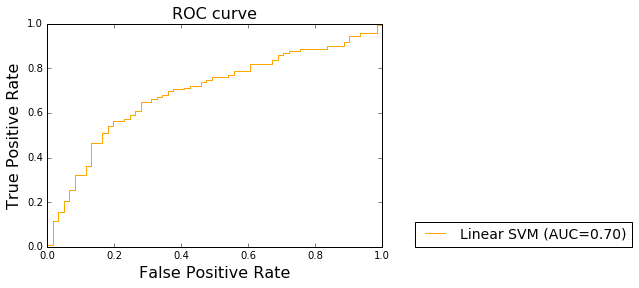

In [41]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, ypred_linear, pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         color='orange',
         label='Linear SVM (AUC=%.2f)' % auc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

### Number of support vectors

The `n_support_` argument of an svm classifier gives us the number of support vectors for each class.

**Question:** How many support vectors does our classifier have? How many is this compared to the number of training samples?

In [42]:
print clf.support_vectors_.shape
print X.shape

(111L, 3000L)
(183L, 3000L)


### Kernel matrix

The kernel matrix is the matrix of size $n \times n$ that has for entry $K_{ij}$ the value $k(x^i, x^j)$, where $k$ is the kernel function used.

In the case of the linear kernel, the kernel function is the dot product.

**Question** Plot the matrix K for the linear kernel.

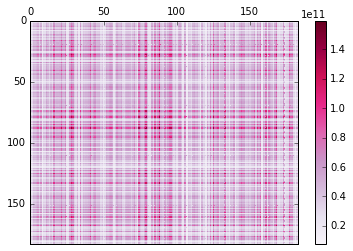

In [43]:
kmatrix = X.dot(X.T)

# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** What do you observe about the values taken by the kernel? What happens if you scale the data before computing the kernel? 

**Question:** How does scaling affect the performance of the linear SVM?

In [44]:
def cross_validate_with_scaling(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 
    
    Scale the training data, and apply same scaling to the test data.
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        
        # Create scaler object
        scaler = preprocessing.StandardScaler() 
        
        # Fit the scaler and transform training data
        Xtr = scaler.fit_transform(Xtr)

        
        # Transform test data
        Xte = scaler.transform(Xte)
        
        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Compute decision function on test data
        yte_pred = classifier.decision_function(Xte)
        
        # Update pred
        pred[te] = yte_pred
        
    return pred

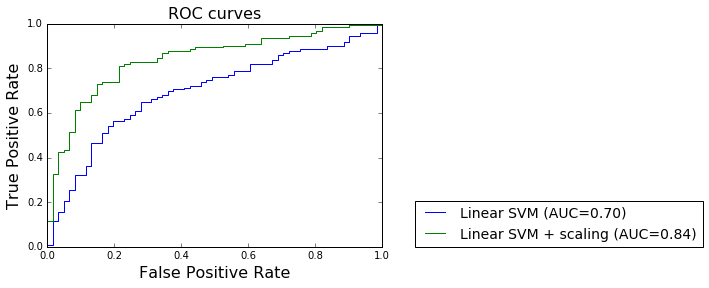

In [45]:
clf = svm.SVC(kernel='linear') 
ypred_linear_scaled = cross_validate_with_scaling(X, y, clf, folds)

fpr_s, tpr_s, thresholds_s = metrics.roc_curve(y, ypred_linear_scaled, pos_label=1)
auc_s = metrics.auc(fpr_s, tpr_s)

plt.plot(fpr,
         tpr,
         label='Linear SVM (AUC=%.2f)' % auc)
plt.plot(fpr_s,
         tpr_s,
         label='Linear SVM + scaling (AUC=%.2f)' % auc_s)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

**Question:** Now optimize for the C-parameter within each loop of the cross-validation. Plot the new ROC curve.

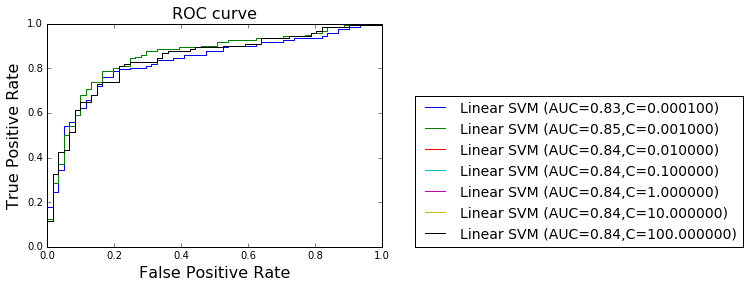

In [46]:
from sklearn import grid_search
parameters_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
colors=['b','g','r','c','m','y','k']
n=0
for c in parameters_dict['C']:
    clf = svm.SVC(kernel='linear',C=c)
    ypred_linear = cross_validate_with_scaling(X, y, clf, folds)
    fpr, tpr, thresholds = metrics.roc_curve(y, ypred_linear, pos_label=1)
    auc = metrics.auc(fpr, tpr)

    plt.plot(fpr,
             tpr,
             color=colors[n],
             label='Linear SVM (AUC=%.2f,C=%f)' % (auc,c))
    n+=1
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc=(1.1, 0), fontsize=14)



## Polynomial kernels

We will use SVMs with kernels of the form $k(x, x') = (\langle x, x' \rangle + r)^d$.

**Question** Plot kernel matrices for $r=0, d=2$.

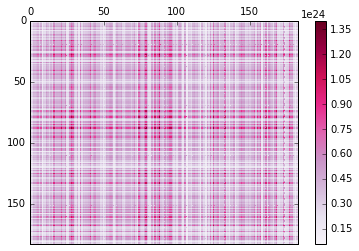

In [47]:
r=0
d=2
kmatrix = (X.dot(X.T)+r)
kmatrix = np.dot(kmatrix,kmatrix.T)

# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** What do you observe? What is going to happen if you increase $d$? How do you think this will affect the SVM? Cross-validate the SVM and plot the ROC curve.

In [ ]:

clf_l = svm.SVC(kernel='linear')
clf_p = svm.SVC(kernel='poly',degree=2,coef0=1e6)
ypred_quaratic=cross_validate(X, y, clf_p, folds)
ypred_linear_scaled = cross_validate_with_scaling(X, y, clf_l, folds)

fpr_s, tpr_s, thresholds_s = metrics.roc_curve(y, ypred_linear_scaled, pos_label=1)
auc_s = metrics.auc(fpr_s, tpr_s)

fpr_q, tpr_q, thresholds_q = metrics.roc_curve(y, ypred_quaratic, pos_label=1)
auc_q = metrics.auc(fpr_q, tpr_q)

# Plot
plt.plot(fpr_s, tpr_s,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_s)
plt.plot(fpr_q, tpr_q,
            label='Quadratic SVM (AUC=%.2f)' % auc_q)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

**Question** What value for $r$ can change this behavior? Plot the corresponding kernel matrix.

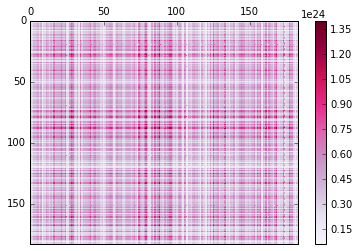

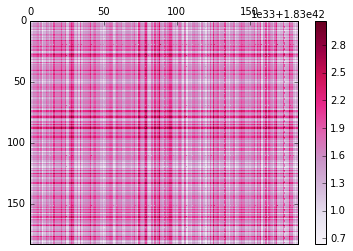

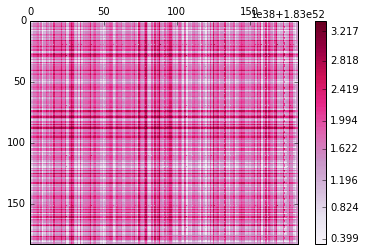

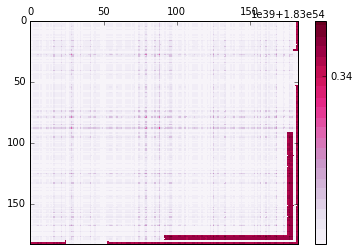

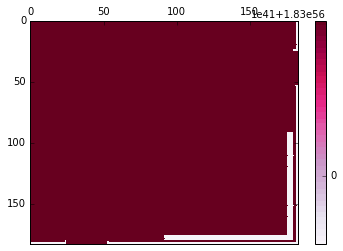

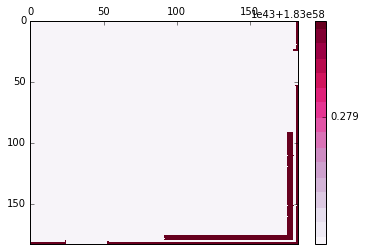

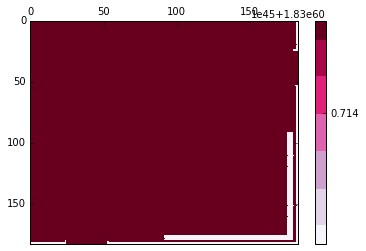

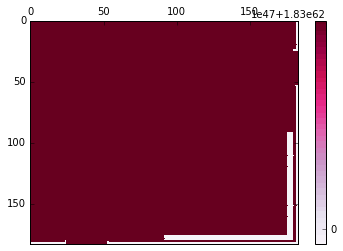

In [29]:
#scaler = preprocessing.StandardScaler() 
#Xs = scaler.fit_transform(X)
R=[1e8,1e20,1e25,1e26,1e27,1e28,1e29,1e30]
d=2
for r in R:
    
    kmatrix = (X.dot(X.T)+r)
    kmatrix=np.dot(kmatrix,kmatrix.T)

    # heatmap + color map
    plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

    # plot colorbar to the right
    plt.colorbar()

    # set axes boundaries
    plt.xlim([0, X.shape[0]])
    plt.ylim([0, X.shape[0]])

    # flip the y-axis
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    
    plt.show()


**Question** Now evaluate an SVM with polynomial kernel of degree d=2 and value for r as above.

In [ ]:
clf_pr = svm.SVC(kernel='poly',degree=2,coef0=1e11)
ypred_qr=cross_validate(X, y, clf_pr, folds)

fpr_qr, tpr_qr, thresholds_qr = metrics.roc_curve(y, ypred_qr, pos_label=1)
auc4 = metrics.auc(fpr_q, tpr_q)
# Plot
plt.plot(fpr_s, tpr_s,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_s)
plt.plot(fpr_qr, tpr_qr,
            label='Quadratic SVM (AUC=%.2f)' % auc4)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

## Gaussian RBF kernels

We will use SVMs with kernels of the form $k(x, x') = \exp \left(-\gamma ||x - x'||^2 \right)$.

The following code efficiently computes the pairwise squared distances between all items in X, that is to say the matrix $P$ such that $P_{ij} = ||x^i - x^j||^2$.

In [16]:
from scipy.spatial.distance import pdist, squareform
pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))
print pairwise_sq_dists

[[  0.00000000e+00   5.56839405e+09   1.01529939e+09 ...,   5.66736558e+09
    1.62989710e+10   4.82791417e+09]
 [  5.56839405e+09   0.00000000e+00   5.62636890e+09 ...,   6.68642798e+08
    3.85460357e+09   1.06933502e+09]
 [  1.01529939e+09   5.62636890e+09   0.00000000e+00 ...,   5.81132184e+09
    1.62813686e+10   4.91739274e+09]
 ..., 
 [  5.66736558e+09   6.68642798e+08   5.81132184e+09 ...,   0.00000000e+00
    3.34854880e+09   6.93944296e+08]
 [  1.62989710e+10   3.85460357e+09   1.62813686e+10 ...,   3.34854880e+09
    0.00000000e+00   5.18252764e+09]
 [  4.82791417e+09   1.06933502e+09   4.91739274e+09 ...,   6.93944296e+08
    5.18252764e+09   0.00000000e+00]]


**Question** Plot kernel matrices for varying values of $\gamma$. What do you observe? What is going to be the impact on the SVM? What happens with very very small values of $\gamma$? Check your intuitions by cross-validating SVMs with these various kernels.

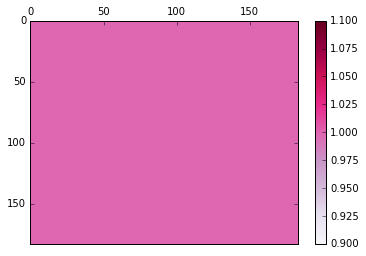

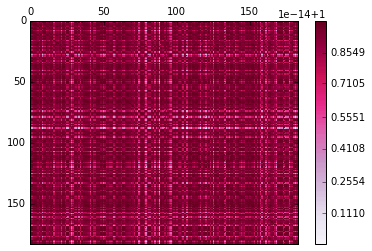

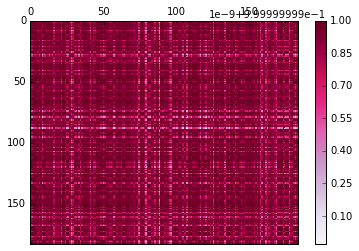

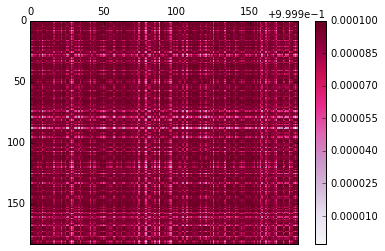

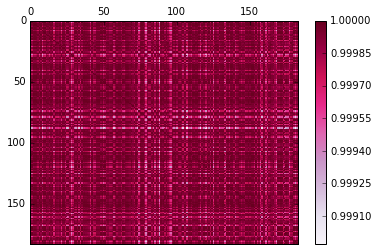

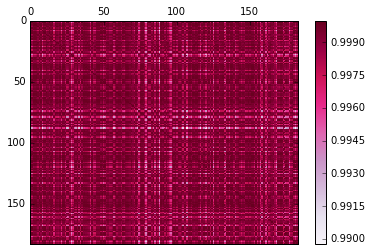

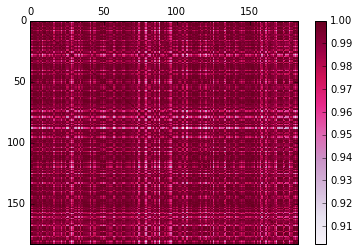

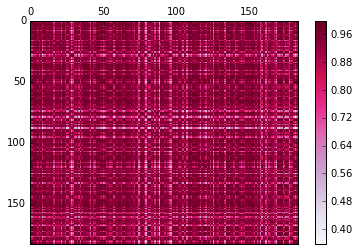

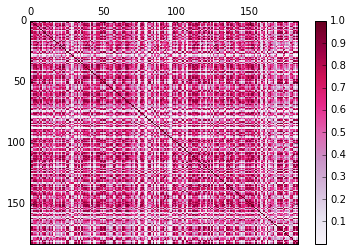

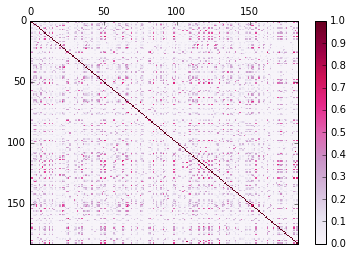

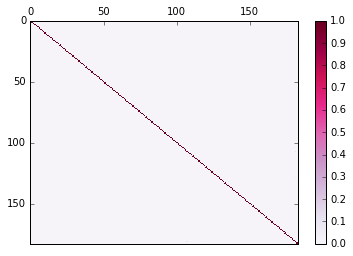

In [26]:
GAMMA=[1e-30,1e-25,1e-20,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8]
for gamma in GAMMA:
    kmatrix = np.exp(-gamma*pairwise_sq_dists)

    # heatmap + color map
    plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

    # plot colorbar to the right
    plt.colorbar()

    # set axes boundaries
    plt.xlim([0, X.shape[0]])
    plt.ylim([0, X.shape[0]])

    # flip the y-axis
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    
    plt.show()

## (Bonus) Scaling the kernel matrix.

What we have observed here is a phenomenon of diagonal dominance in the kernel matrix. 

One way to address this is to re-scale the kernel matrix in the following way:
$\hat K_{ij} = \frac{K_{ij}}{\sqrt{K_{ii} K_{jj}}}$.

To implement this you can pass your own kernel function or matrix to the `kernel` parameter of the SVM.

**Question:** Write a function `scaled_quadratic_kernel` that computes the scaled quadratic kernel matrix between two data arrays.

In [ ]:
def scaled_quadratic_kernel(X1, X2):
    
    """ Custom scaled RBF kernel.
    
    The RBF kernel between X1 and X2 is scaled to avoid diagonal dominance,
    by applying k(X1i, X2j) <-- k(X1i, X2j) / sqrt(k(X1i, X1i) k(X2j, X2j))   
   
    Parameters:
    -----------
    X1: (n_samples1, n_features) np.array
        First data matrix.
    X2: (n_samples2, n_features) np.array
        Second data matrix.
        
    Return:
    -------
    K: (n_samples1, n_samples2) np.array
        Kernel matrix between samples from X1 and samples from X2.
    """
    # TODO   

**Question:** Plot the corresponding kernel matrix. Does it match your expectations?

**Question:** In the 0.17 version of scikit-learn, it isn't possible to use a custom kernel function within GridSearchCV. Set the C parameter to 1 and compare your custom kernel with the quadratic kernel (d=2) on the gene expression data.